In [14]:
## Import necessary libraries
import cv2
import os
import gc 
import numpy as np
import pandas as pd

from joblib import dump, load

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
torch.set_default_tensor_type(torch.FloatTensor)

In [15]:
## Set (hyper)parameters and specify the hardware for computation
# We use the Mean and Standard Deviation from ResNet to normalize our data corresponding to the original data used in ResNet
IMG_SIZE = 224 # image size does not have to be equal to 224 (same as image size in ResNet) in the case of feature extractor
BATCH_SIZE = 64 # set the no of images processed in each iteration
IMG_MEAN = [0.485, 0.456, 0.406] # Mean for normalization
IMG_STD = [0.229, 0.224, 0.225] # Standard Deviation for normalization
EPOCHS = 100


val_transforms = transforms.Compose([ # for validation data
    transforms.Resize(256), # This line is requeired to use ResNet as pre-trained model
    transforms.CenterCrop(IMG_SIZE), # center crop to ensure it matches the desired "IMG_SIZE"
    transforms.ToTensor(),
    transforms.Normalize(IMG_MEAN, IMG_STD)
])

cam_transform = transforms.Compose([ # for displaing image
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE)
    ])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Test_Results = pd.read_csv("/scratch/network/ao3526/Results/BldType/CNN_ResNet18/60_20_20/Results.csv")
Test_Results.head(5)

,ID,Ground Truth,Predicted Value
0,24633,1,1
1,15892,2,1
2,75689,1,1
3,82079,2,1
4,17016,1,1


In [16]:
# Download data by using custom dataset class
satellite_image_path = "/scratch/network/ao3526/3Bands_new/"
cityyear = "StPaul2021"
bit = "8Bit"
street_view_image_path = "/scratch/network/ao3526/GSV_Image"

class CombinedDataset(Dataset):
    def __init__(self, satellite_data, street_view_data, is_train=True): # define instance variable that is used in this class
        self.satellite_data= satellite_data
        self.street_view_data= street_view_data
        self.label_encoder = LabelEncoder()
        self.street_view_data['BldType_encoded'] = self.label_encoder.fit_transform(self.street_view_data['BldType'])
        if is_train: # check if it is training or validation data. Process the transform
            self.transforms = train_transforms
        else:
            self.transforms = val_transforms

    def __getitem__(self, index): # return single data item at the specified index
        # street view image
        street_view_image_name = os.path.join(street_view_image_path, f"GSV_{index}.jpg") # Construct the path for the "north" image
        
        if os.path.exists(street_view_image_name):
            street_view_img = Image.open(street_view_image_name) # open the image
        else:
            street_view_img = Image.new("RGB", (IMG_SIZE, IMG_SIZE), color=(128, 128, 128)) # Assign gray images for the ID without images
        
        street_view_img = self.transforms(street_view_img)
        img_id = self.street_view_data.id.iloc[index] # get the image ID
        
        # satellite image
        satellite_image_name = os.path.join(satellite_image_path, f"{cityyear}_{index}_{bit}_3bands.tif") # construct the path for the image
        satellite_img = Image.open(satellite_image_name)
        satellite_img = self.transforms(satellite_img) # apply the data transformation
        
        # other data
        label = self.street_view_data.BldType_encoded.iloc[index]
        
        return satellite_img, street_view_img, label, img_id

    def __len__(self): # return the total no of samples
        return len(self.satellite_data)
    
    def get_label_encoder(self):
        return self.label_encoder


In [17]:
class CombinedModel(nn.Module):
    def __init__(self, pretrained_model, num_classes=3):
        super(CombinedModel, self).__init__()
        num_features = pretrained_model.fc.in_features
        self.cnn = nn.Sequential(*list(pretrained_model.children())[:-1])
        self.fc = nn.Linear(num_features * 2, num_classes)
    
    def forward(self, satellite_img, street_view_img):
        cnn_features_satellite = self.cnn(satellite_img).view(satellite_img.size(0), -1)
        cnn_features_street_view = self.cnn(street_view_img).view(street_view_img.size(0), -1)  # Fix this line
        combined_features = torch.cat([cnn_features_satellite, cnn_features_street_view], dim=1).float()    
        output = self.fc(combined_features)
        return output
    

combined_model = models.resnet18()
state_dict = torch.load("/scratch/network/ao3526/ResNet18/resnet18.pth")
combined_model.load_state_dict(state_dict)
combined_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
##  set up for the GradCAM++ (Gradient-weighted Class Activation Mapping) technique to visualize the activation regions in a neural network model
target_layers = [combined_model.layer4[-1]] # specify the layers
cam = GradCAMPlusPlus(model=combined_model, target_layers=target_layers)
targets = None

In [19]:
## Use GradCAM++ to visualize the activation regions of a specific image
index = 75689
satellite_image_name = os.path.join(satellite_image_path, f"{cityyear}_{index}_{bit}_3bands.tif")

img = Image.open(satellite_image_name)
x = val_transforms(img) # apply validation transform
img = cam_transform(img) # apply another transformation to show the image

grayscale_cam = cam(input_tensor=x.unsqueeze(0), targets=targets, aug_smooth=False) # Use GradCAM++ to generate the heatmap
grayscale_cam = grayscale_cam[0, :] # select first (presumably only) heatmap
visualization = show_cam_on_image(np.array(img) / 255, grayscale_cam, use_rgb=True) # overlay the heatmap onto the original image & create visualization of the activation regions
vis = Image.fromarray(visualization) # reconvert NumPy array to PIL image to display the image

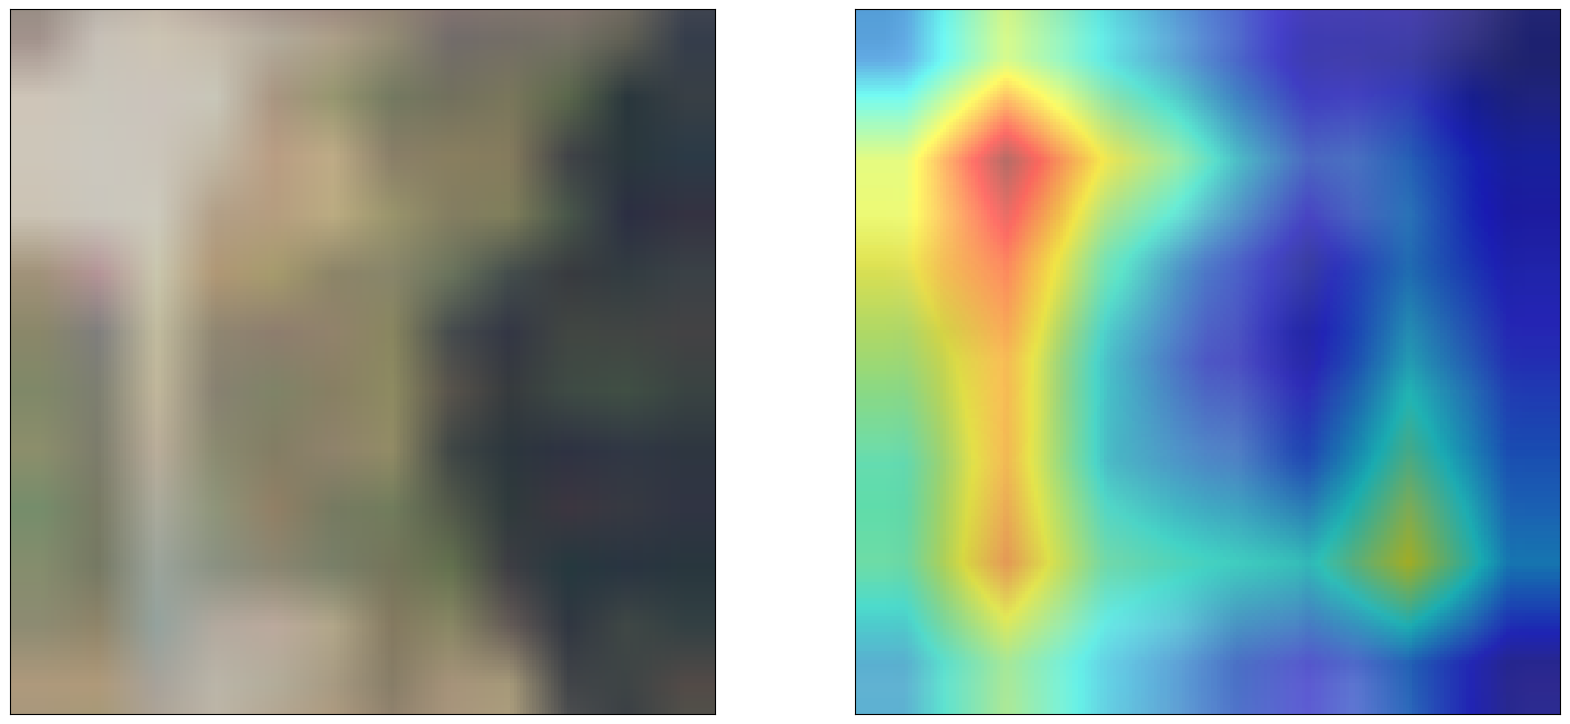

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax in axes: # hide the x & y axes tickes and labels for each plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax = axes[0]
ax.imshow(img)

ax = axes[1]
ax.imshow(vis)

In [21]:
## Use GradCAM++ to visualize the activation regions of a specific image
street_view_image_name = os.path.join(street_view_image_path, f"GSV_{index}.jpg")

img = Image.open(street_view_image_name)
x = val_transforms(img) # apply validation transform
img = cam_transform(img) # apply another transformation to show the image

grayscale_cam = cam(input_tensor=x.unsqueeze(0), targets=targets, aug_smooth=False) # Use GradCAM++ to generate the heatmap
grayscale_cam = grayscale_cam[0, :] # select first (presumably only) heatmap
visualization = show_cam_on_image(np.array(img) / 255, grayscale_cam, use_rgb=True) # overlay the heatmap onto the original image & create visualization of the activation regions
vis = Image.fromarray(visualization) # reconvert NumPy array to PIL image to display the image

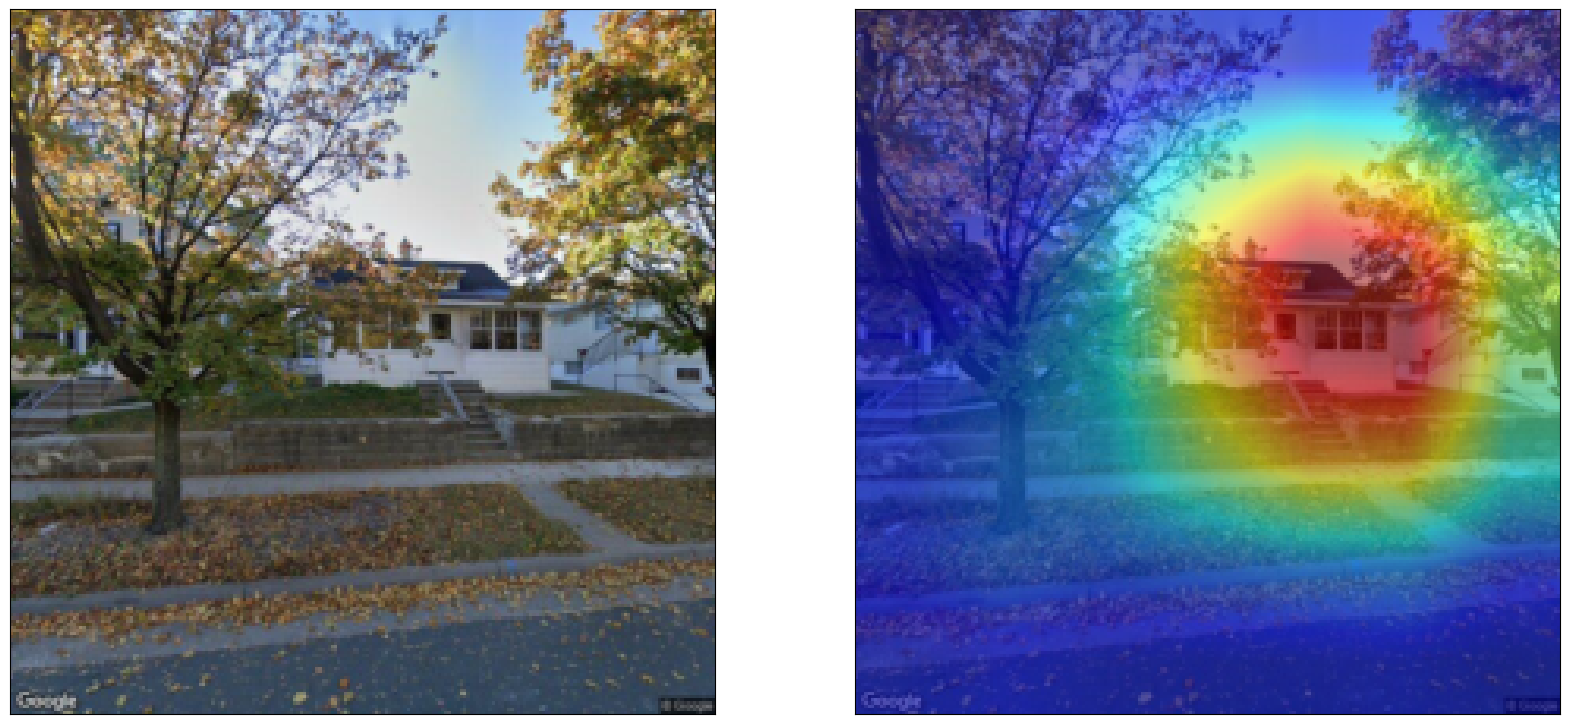

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax in axes: # hide the x & y axes tickes and labels for each plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax = axes[0]
ax.imshow(img)

ax = axes[1]
ax.imshow(vis)

### Image 2

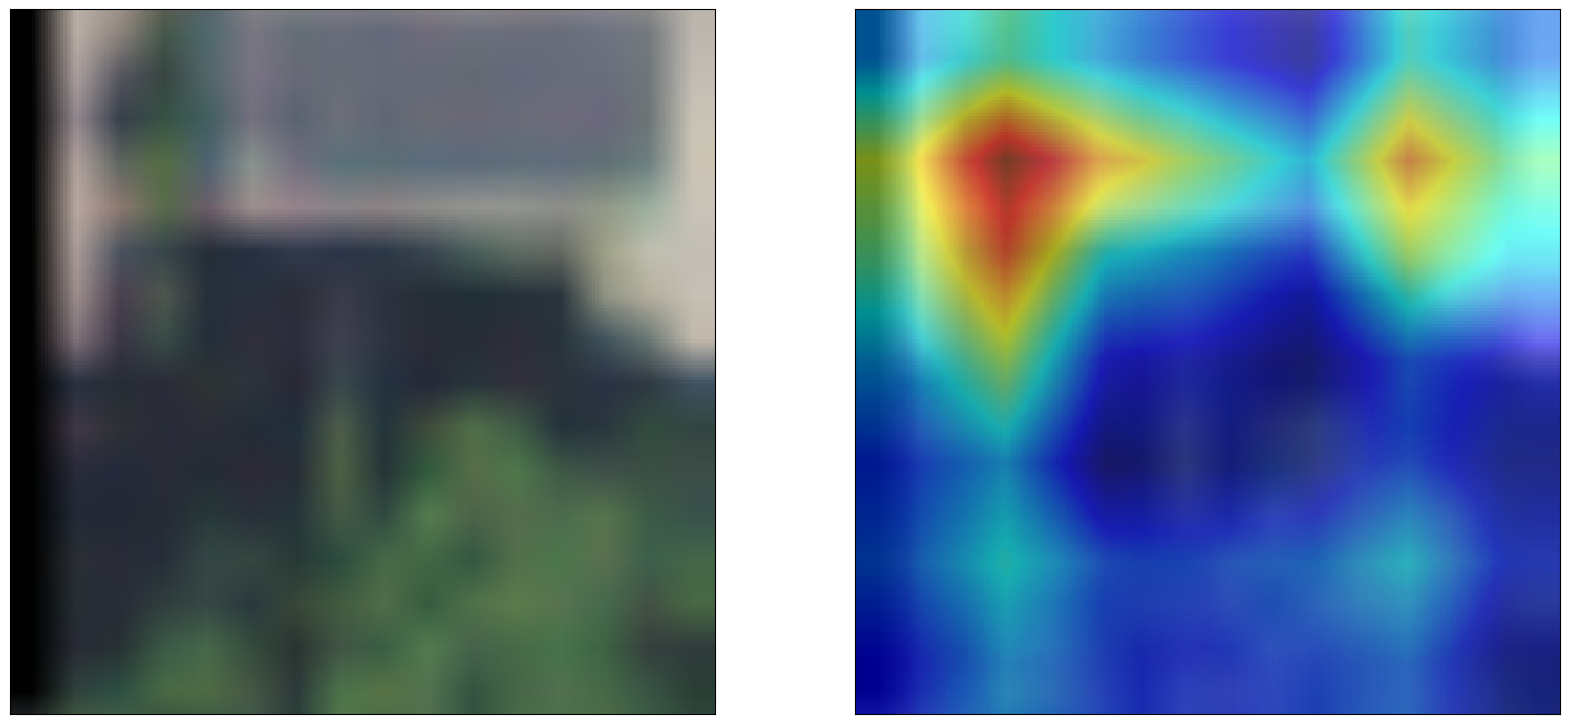

In [23]:
## Use GradCAM++ to visualize the activation regions of a specific image
index = 17544
satellite_image_name = os.path.join(satellite_image_path, f"{cityyear}_{index}_{bit}_3bands.tif")

img = Image.open(satellite_image_name)
x = val_transforms(img) # apply validation transform
img = cam_transform(img) # apply another transformation to show the image

grayscale_cam = cam(input_tensor=x.unsqueeze(0), targets=targets, aug_smooth=False) # Use GradCAM++ to generate the heatmap
grayscale_cam = grayscale_cam[0, :] # select first (presumably only) heatmap
visualization = show_cam_on_image(np.array(img) / 255, grayscale_cam, use_rgb=True) # overlay the heatmap onto the original image & create visualization of the activation regions
vis = Image.fromarray(visualization) # reconvert NumPy array to PIL image to display the image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax in axes: # hide the x & y axes tickes and labels for each plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax = axes[0]
ax.imshow(img)

ax = axes[1]
ax.imshow(vis)

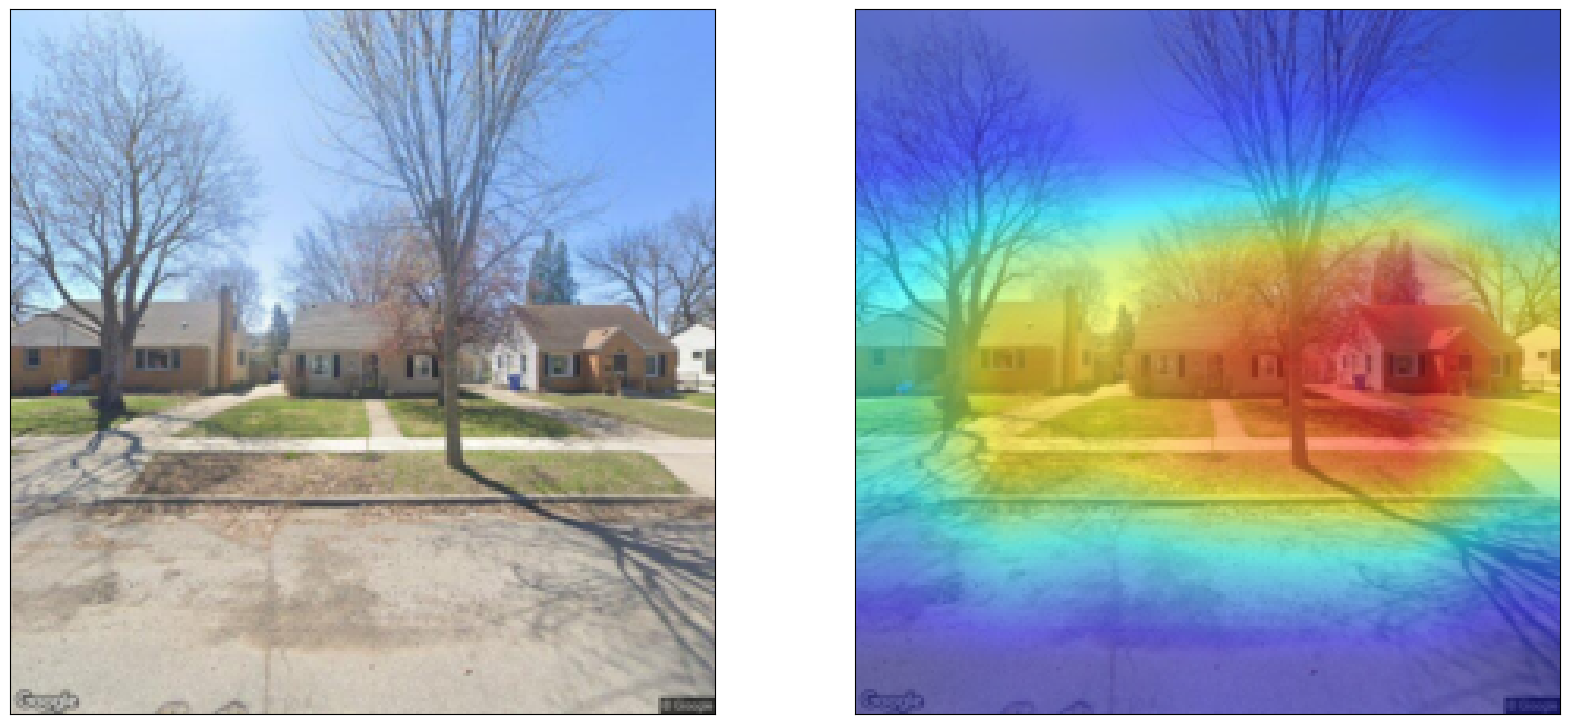

In [24]:
## Use GradCAM++ to visualize the activation regions of a specific image
street_view_image_name = os.path.join(street_view_image_path, f"GSV_{index}.jpg")

img = Image.open(street_view_image_name)
x = val_transforms(img) # apply validation transform
img = cam_transform(img) # apply another transformation to show the image

grayscale_cam = cam(input_tensor=x.unsqueeze(0), targets=targets, aug_smooth=False) # Use GradCAM++ to generate the heatmap
grayscale_cam = grayscale_cam[0, :] # select first (presumably only) heatmap
visualization = show_cam_on_image(np.array(img) / 255, grayscale_cam, use_rgb=True) # overlay the heatmap onto the original image & create visualization of the activation regions
vis = Image.fromarray(visualization) # reconvert NumPy array to PIL image to display the image

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax in axes: # hide the x & y axes tickes and labels for each plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax = axes[0]
ax.imshow(img)

ax = axes[1]
ax.imshow(vis)

## Truth is MFHs but predict as SFHs

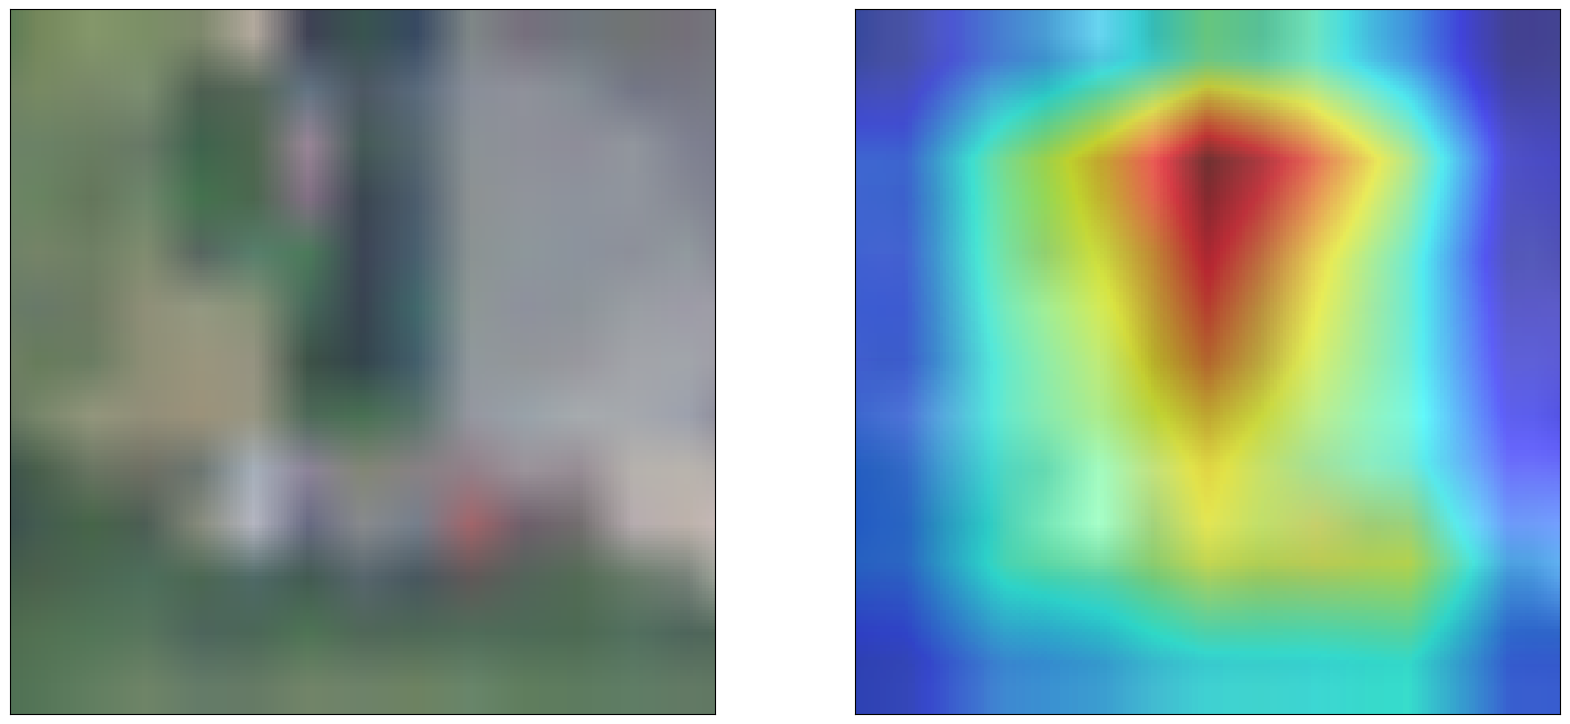

In [25]:
## Use GradCAM++ to visualize the activation regions of a specific image
index = 15892
satellite_image_name = os.path.join(satellite_image_path, f"{cityyear}_{index}_{bit}_3bands.tif")

img = Image.open(satellite_image_name)
x = val_transforms(img) # apply validation transform
img = cam_transform(img) # apply another transformation to show the image

grayscale_cam = cam(input_tensor=x.unsqueeze(0), targets=targets, aug_smooth=False) # Use GradCAM++ to generate the heatmap
grayscale_cam = grayscale_cam[0, :] # select first (presumably only) heatmap
visualization = show_cam_on_image(np.array(img) / 255, grayscale_cam, use_rgb=True) # overlay the heatmap onto the original image & create visualization of the activation regions
vis = Image.fromarray(visualization) # reconvert NumPy array to PIL image to display the image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax in axes: # hide the x & y axes tickes and labels for each plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax = axes[0]
ax.imshow(img)

ax = axes[1]
ax.imshow(vis)

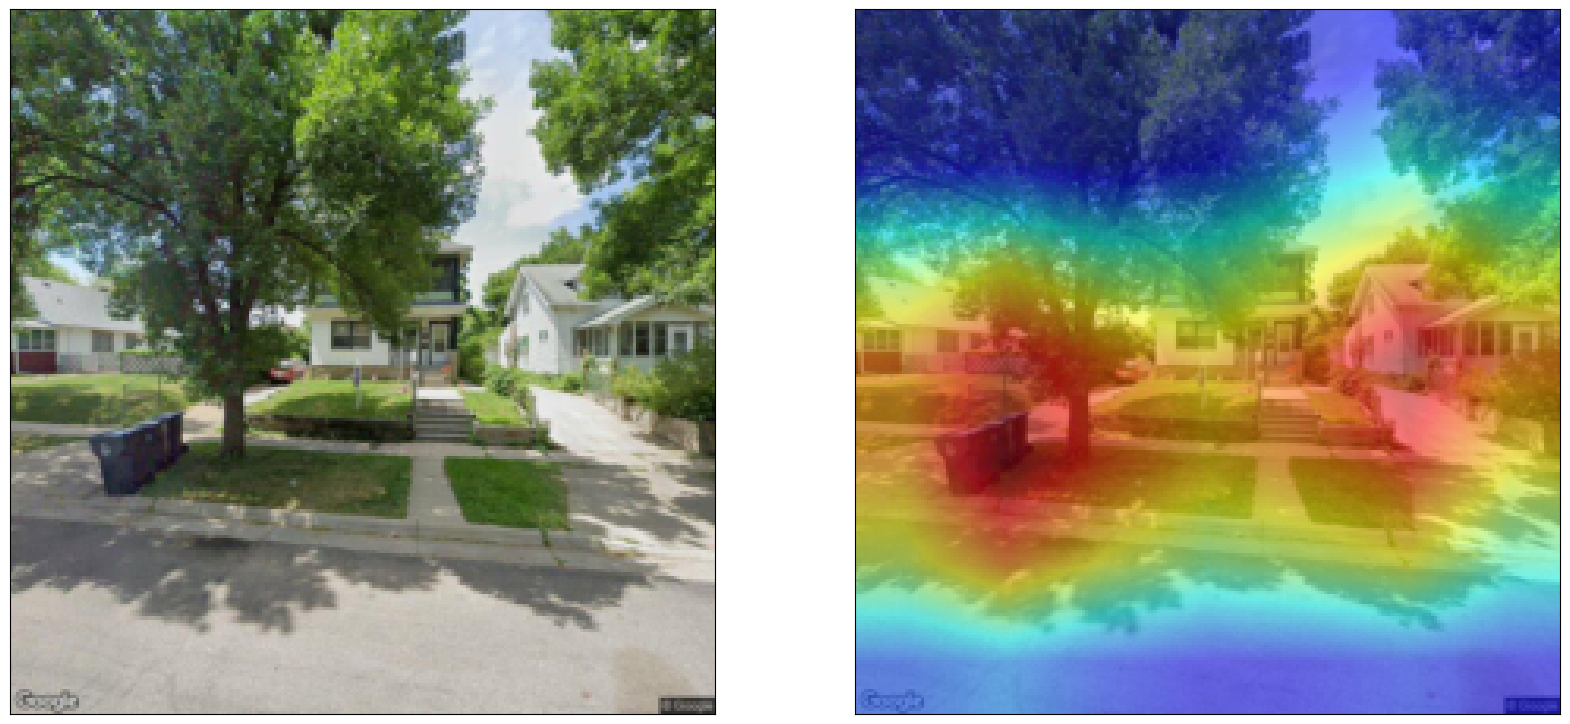

In [26]:
## Use GradCAM++ to visualize the activation regions of a specific image
street_view_image_name = os.path.join(street_view_image_path, f"GSV_{index}.jpg")

img = Image.open(street_view_image_name)
x = val_transforms(img) # apply validation transform
img = cam_transform(img) # apply another transformation to show the image

grayscale_cam = cam(input_tensor=x.unsqueeze(0), targets=targets, aug_smooth=False) # Use GradCAM++ to generate the heatmap
grayscale_cam = grayscale_cam[0, :] # select first (presumably only) heatmap
visualization = show_cam_on_image(np.array(img) / 255, grayscale_cam, use_rgb=True) # overlay the heatmap onto the original image & create visualization of the activation regions
vis = Image.fromarray(visualization) # reconvert NumPy array to PIL image to display the image

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax in axes: # hide the x & y axes tickes and labels for each plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax = axes[0]
ax.imshow(img)

ax = axes[1]
ax.imshow(vis)

## Truth is non-residential but predict as SFHs

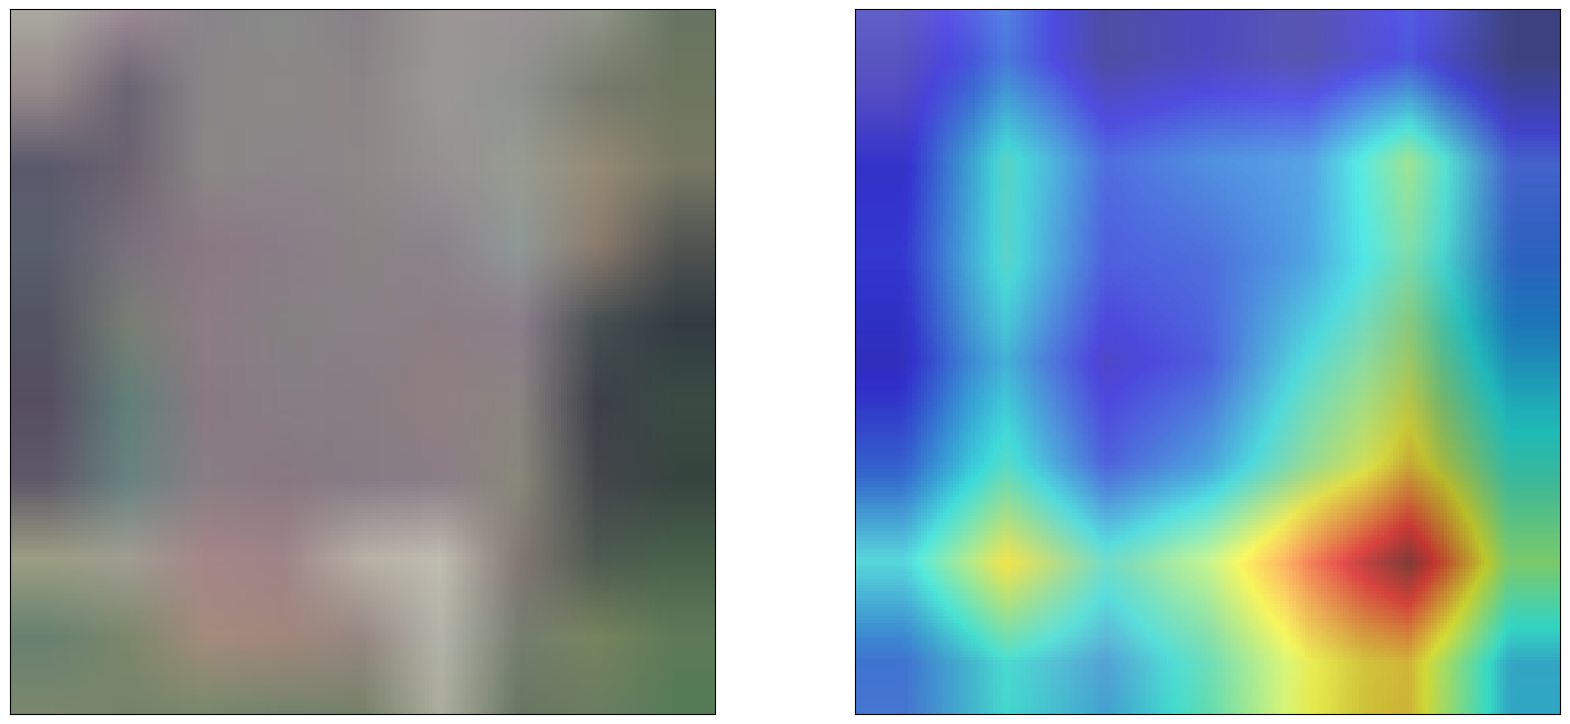

In [39]:
## Use GradCAM++ to visualize the activation regions of a specific image
index = 49276
satellite_image_name = os.path.join(satellite_image_path, f"{cityyear}_{index}_{bit}_3bands.tif")

img = Image.open(satellite_image_name)
x = val_transforms(img) # apply validation transform
img = cam_transform(img) # apply another transformation to show the image

grayscale_cam = cam(input_tensor=x.unsqueeze(0), targets=targets, aug_smooth=False) # Use GradCAM++ to generate the heatmap
grayscale_cam = grayscale_cam[0, :] # select first (presumably only) heatmap
visualization = show_cam_on_image(np.array(img) / 255, grayscale_cam, use_rgb=True) # overlay the heatmap onto the original image & create visualization of the activation regions
vis = Image.fromarray(visualization) # reconvert NumPy array to PIL image to display the image
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax in axes: # hide the x & y axes tickes and labels for each plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax = axes[0]
ax.imshow(img)

ax = axes[1]
ax.imshow(vis)

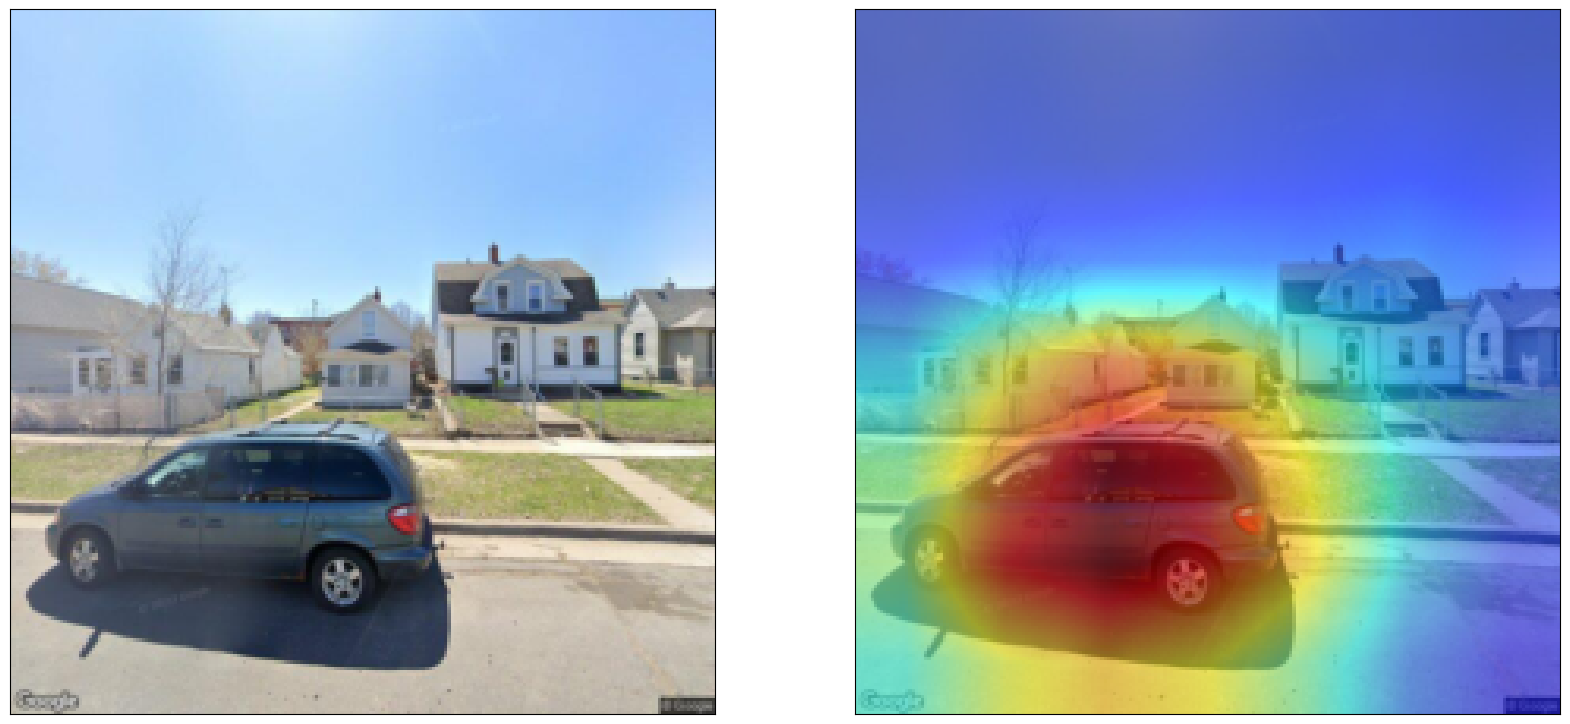

In [40]:
## Use GradCAM++ to visualize the activation regions of a specific image
street_view_image_name = os.path.join(street_view_image_path, f"GSV_{index}.jpg")

img = Image.open(street_view_image_name)
x = val_transforms(img) # apply validation transform
img = cam_transform(img) # apply another transformation to show the image

grayscale_cam = cam(input_tensor=x.unsqueeze(0), targets=targets, aug_smooth=False) # Use GradCAM++ to generate the heatmap
grayscale_cam = grayscale_cam[0, :] # select first (presumably only) heatmap
visualization = show_cam_on_image(np.array(img) / 255, grayscale_cam, use_rgb=True) # overlay the heatmap onto the original image & create visualization of the activation regions
vis = Image.fromarray(visualization) # reconvert NumPy array to PIL image to display the image

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax in axes: # hide the x & y axes tickes and labels for each plot
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

ax = axes[0]
ax.imshow(img)

ax = axes[1]
ax.imshow(vis)